End-to-End Travel Cost Regression

building  a model to predict:

Total trip cost = flight price + estimated hotel cost

In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [3]:
import os
os.chdir(r"C:\LABMENTIX\TEAM PROJECt")


In [4]:
flights = pd.read_csv("dataset/flights.csv")
hotels  = pd.read_csv("dataset/hotels.csv")
users   = pd.read_csv("dataset/users.csv")


In [5]:
print(flights.shape)
print(hotels.shape)
print(users.shape)


(271888, 10)
(40552, 8)
(1340, 5)


In [6]:
#CLEANING
# ---------- FLIGHTS ----------
flights.drop_duplicates(inplace=True)
flights.dropna(subset=["price"], inplace=True)
flights.fillna(method="ffill", inplace=True)

# ---------- HOTELS ----------
hotels.drop_duplicates(inplace=True)
hotels.fillna(method="ffill", inplace=True)

# ---------- USERS ----------
users.drop_duplicates(inplace=True)
users.fillna(method="ffill", inplace=True)

print("Flights:", flights.shape)
print("Hotels:", hotels.shape)
print("Users:", users.shape)


Flights: (271888, 10)
Hotels: (40552, 8)
Users: (1340, 5)


C:\Users\kbhuv\AppData\Local\Temp\ipykernel_36076\457427846.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights.fillna(method="ffill", inplace=True)
C:\Users\kbhuv\AppData\Local\Temp\ipykernel_36076\457427846.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hotels.fillna(method="ffill", inplace=True)
C:\Users\kbhuv\AppData\Local\Temp\ipykernel_36076\457427846.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  users.fillna(method="ffill", inplace=True)


In [10]:
# Flights CSV
print("FLIGHTS COLUMNS:")
print(flights.columns.tolist())
print(flights.head(), "\n")

# Hotels CSV
print("HOTELS COLUMNS:")
print(hotels.columns.tolist())
print(hotels.head(), "\n")

# Users CSV
print("USERS COLUMNS:")
print(users.columns.tolist())
print(users.head())


FLIGHTS COLUMNS:
['travelCode', 'userCode', 'from', 'to', 'flightType', 'price', 'time', 'distance', 'agency', 'date']
   travelCode  userCode                from                  to  flightType  \
0           0         0         Recife (PE)  Florianopolis (SC)  firstClass   
1           0         0  Florianopolis (SC)         Recife (PE)  firstClass   
2           1         0       Brasilia (DF)  Florianopolis (SC)  firstClass   
3           1         0  Florianopolis (SC)       Brasilia (DF)  firstClass   
4           2         0        Aracaju (SE)       Salvador (BH)  firstClass   

     price  time  distance       agency        date  
0  1434.38  1.76    676.53  FlyingDrops  09/26/2019  
1  1292.29  1.76    676.53  FlyingDrops  09/30/2019  
2  1487.52  1.66    637.56      CloudFy  10/03/2019  
3  1127.36  1.66    637.56      CloudFy  10/04/2019  
4  1684.05  2.16    830.86      CloudFy  10/10/2019   

HOTELS COLUMNS:
['travelCode', 'userCode', 'name', 'place', 'days', 'price', 'to

In [14]:
print(users.columns.tolist())


['code', 'company', 'name', 'gender', 'age']


In [17]:
# Average hotel cost per destination city
hotel_cost_city = (
    hotels.groupby("place")["hotel_cost"]
    .mean()
    .reset_index()
)

hotel_cost_city.head()


,place,hotel_cost
0,Aracaju (SE),14962.305935
1,Brasilia (DF),15108.859445
2,Campo Grande (MS),14110.879111
3,Florianopolis (SC),9242.595975
4,Natal (RN),13824.070174


MERGE FLIGHTS + USERS + CITY-LEVEL HOTEL COST

In [18]:
# Merge flights with users 
df = flights.merge(
    users,
    left_on="userCode",
    right_on="code",
    how="left"
)

print("After merging users:", df.shape)

# Merge with aggregated hotel cost by destination city
df = df.merge(
    hotel_cost_city,
    left_on="to",
    right_on="place",
    how="left"
)

print("After merging hotel cost:", df.shape)


After merging users: (271888, 15)
After merging hotel cost: (271888, 17)


In [19]:
#CREATE FINAL TARGET — total_trip_cost
# Create total trip cost (TARGET variable)
df["total_trip_cost"] = df["price"] + df["hotel_cost"]

# Sanity check
df[["price", "hotel_cost", "total_trip_cost"]].head()


,price,hotel_cost,total_trip_cost
0,1434.38,9242.595975,10676.975975
1,1292.29,14892.740060,16185.030060
2,1487.52,9242.595975,10730.115975
3,1127.36,15108.859445,16236.219445
4,1684.05,13965.235309,15649.285309


In [20]:
# Drop leakage and unnecessary columns
df.drop(
    columns=[
        "price",      # part of target
        "hotel_cost", # part of target
        "travelCode",
        "code",       # duplicate user id
        "place"       # duplicate city column
    ],
    inplace=True,
    errors="ignore"
)

print(df.columns)
print(df.shape)


Index(['userCode', 'from', 'to', 'flightType', 'time', 'distance', 'agency',
       'date', 'company', 'name', 'gender', 'age', 'total_trip_cost'],
      dtype='object')
(271888, 13)


In [21]:
#DATE FEATURE ENGINEERING
# Convert date column
df["date"] = pd.to_datetime(df["date"])

# Extract useful time features
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["weekday"] = df["date"].dt.weekday

# Drop original date column
df.drop(columns=["date"], inplace=True)

print(df.columns)
print(df.head())


Index(['userCode', 'from', 'to', 'flightType', 'time', 'distance', 'agency',
       'company', 'name', 'gender', 'age', 'total_trip_cost', 'day', 'month',
       'weekday'],
      dtype='object')
   userCode                from                  to  flightType  time  \
0         0         Recife (PE)  Florianopolis (SC)  firstClass  1.76   
1         0  Florianopolis (SC)         Recife (PE)  firstClass  1.76   
2         0       Brasilia (DF)  Florianopolis (SC)  firstClass  1.66   
3         0  Florianopolis (SC)       Brasilia (DF)  firstClass  1.66   
4         0        Aracaju (SE)       Salvador (BH)  firstClass  2.16   

   distance       agency company       name gender  age  total_trip_cost  day  \
0    676.53  FlyingDrops    4You  Roy Braun   male   21     10676.975975   26   
1    676.53  FlyingDrops    4You  Roy Braun   male   21     16185.030060   30   
2    637.56      CloudFy    4You  Roy Braun   male   21     10730.115975    3   
3    637.56      CloudFy    4You  Roy Bra

In [22]:
#ENCODE CATEGORICAL COLUMNS
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = [
    "from", "to", "flightType",
    "agency", "company", "name", "gender"
]

le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print(df.head())
print(df.dtypes)


   userCode  from  to  flightType  time  distance  agency  company  name  \
0         0     5   3           1  1.76    676.53       1        0  1116   
1         0     3   5           1  1.76    676.53       1        0  1116   
2         0     1   3           1  1.66    637.56       0        0  1116   
3         0     3   1           1  1.66    637.56       0        0  1116   
4         0     0   7           1  2.16    830.86       0        0  1116   

   gender  age  total_trip_cost  day  month  weekday  
0       1   21     10676.975975   26      9        3  
1       1   21     16185.030060   30      9        0  
2       1   21     10730.115975    3     10        3  
3       1   21     16236.219445    4     10        4  
4       1   21     15649.285309   10     10        3  
userCode             int64
from                 int32
to                   int32
flightType           int32
time               float64
distance           float64
agency               int32
company              int

In [23]:
#SPLIT FEATURES (X) & TARGET (y)
# Split features and target
X = df.drop("total_trip_cost", axis=1)
y = df["total_trip_cost"]

print(X.shape, y.shape)


(271888, 14) (271888,)


In [24]:
#TRAIN–TEST SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, X_test.shape)


(217510, 14) (54378, 14)


In [25]:
#REGRESSION MODEL

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=42)

In [26]:
#EVALUATE THE MODEL (MAE & R²)

from sklearn.metrics import mean_absolute_error, r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("R2 Score:", r2)


MAE: 0.10919483296696227
R2 Score: 0.999999707032335


In [27]:
import joblib

joblib.dump(model, "end_to_end_travel_cost_model.pkl")
print("Model saved successfully")


Model saved successfully


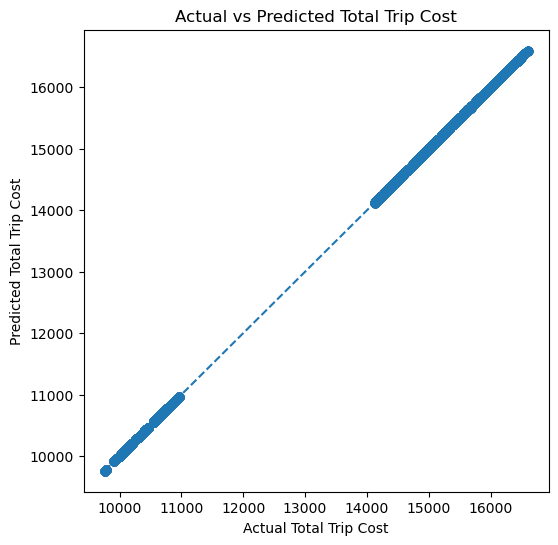

In [28]:
#Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.25)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Actual Total Trip Cost")
plt.ylabel("Predicted Total Trip Cost")
plt.title("Actual vs Predicted Total Trip Cost")
plt.show()


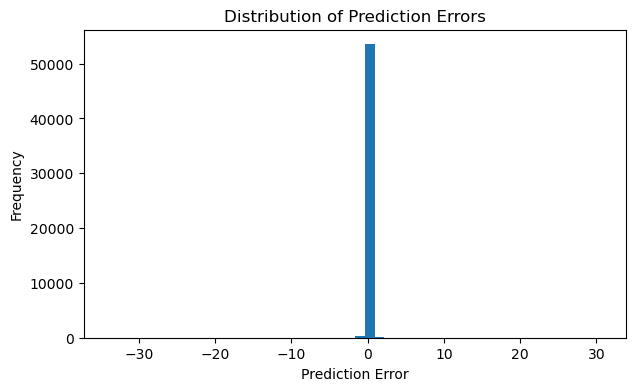

In [29]:
#Error Distribution

errors = y_test - y_pred

plt.figure(figsize=(7,4))
plt.hist(errors, bins=50)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


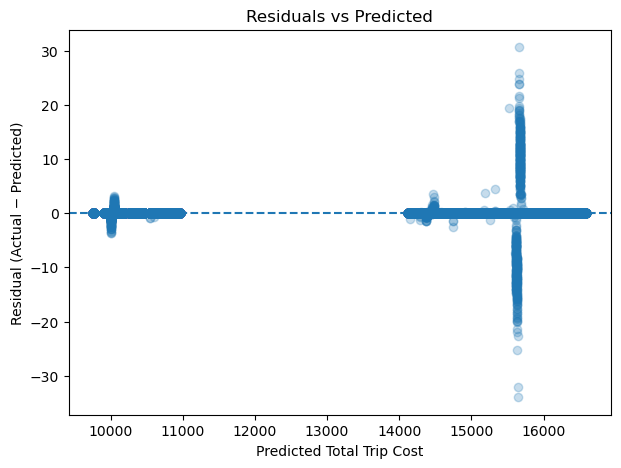

In [30]:
#Residuals vs Predicted (bias check)

plt.figure(figsize=(7,5))
plt.scatter(y_pred, errors, alpha=0.25)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Total Trip Cost")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residuals vs Predicted")
plt.show()


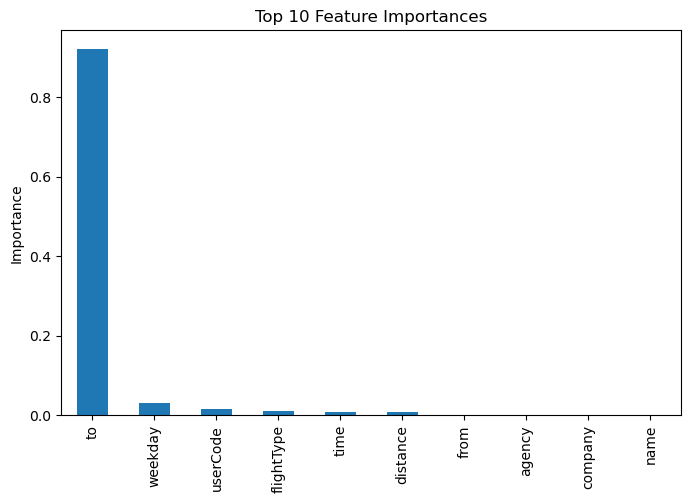

In [31]:
#Feature Importance
import pandas as pd

importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importance.head(10).plot(kind="bar")
plt.ylabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()
